<a href="https://colab.research.google.com/github/Gooogr/Kaggle_Global_Wheat_Detection/blob/master/GWD_YOLO_v4_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gc #garbage collector
import ast # operate with string representation of list
import os
import fnmatch
import json
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow

In [3]:
#Fix seeds
SEED = 42
np.random.seed(seed=SEED)
# tf.random.set_seed(seed=SEED)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# create a symbolic sub-link to avoid 'space' problem
!ln -s /content/drive/My\ Drive/colab_notebooks/Kaggle_Global_Wheat_Detection/ /mydrive

In [6]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Sun Aug  2 17:14:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# add kaggle.json key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gooogr","key":"3355d8a0ad1d1fdfb76ef01a7df4151c"}'}

## Dataset downloading

In [8]:
 ! mkdir ~/.kaggle #inroot folder 
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle -v 

Kaggle API 1.5.4


In [10]:
# Reinstall kaggle API to fix bugs with data downloading
! pip uninstall -y kaggle
! pip install --upgrade pip
! pip install -q kaggle==1.5.6
! kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 8.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.7 MB/s 
Kaggle API 1.5.6


In [11]:
! kaggle competitions download -c global-wheat-detection
! unzip -q global-wheat-detection.zip

 99% 601M/607M [00:08<00:00, 80.5MB/s]
100% 607M/607M [00:08<00:00, 76.8MB/s]


In [16]:
# Add image without wheat head in test set (only for check purposes)
! wget --quiet https://interactive-examples.mdn.mozilla.net/media/examples/grapefruit-slice-332-332.jpg \
-O ./test/bad_sample.jpg

### Constants

In [17]:
MAIN_PATH = '/content/'
TRAIN_DIR_PATH = '/content/train'
TEST_DIR_PATH = '/content/test'

## Setting up YOLO Darknet

In [18]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

In [19]:
%%capture
# Uncomment to make absense darknet from scratch 
make_darknet()

In [20]:
# Download pre-trained weights from google disk
!cp /mydrive/yolov4_naive_final.weights /content/  #Change path to reight here
!mv  /content/yolov4_naive_final.weights /content/yolov4_predict.weights

### Prepare config files

In [21]:
! mkdir /content/yolo_config_files
% cd /content/yolo_config_files

/content/yolo_config_files


> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [22]:
%%writefile obj.names
Wheat head

Writing obj.names


> yolo.data

Specify classes amount. Check pathes to other files:<br>
classses = *amount of your classes*<br>
valid  = /content/test.txt<br>
names = /content/yolo_config_files/obj.names<br>
backup = /content/yolo_weights<br>
train  = /content/train.txt<br>

During prediction only  ```names``` string is important.

In [23]:
% cd /content/yolo_config_files

/content/yolo_config_files


In [24]:
%%writefile yolo.data
#classses = 1
#valid = /content/test.txt
names = /content/yolo_config_files/obj.names
#backup = /content/yolo_weights
#train = /content/train.txt

Writing yolo.data


> yolov4.cfg

How to configure cfg file<br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

In [25]:
# #Generate anchors for cfg file
# # Can't open labels because of 49 files without bboxes
# % cd /content/darknet
# ! chmod 777 ./darknet
# ! ./darknet detector calc_anchors \
# /content/yolo_config_files/yolo.data -num_of_clusters 1 -width 608 -height 608 -show
# # Result - 50, 46

In [26]:
% cd /content/yolo_config_files/
! wget --quiet https://raw.githubusercontent.com/Gooogr/Kaggle_Global_Wheat_Detection/master/yolov4-custom.cfg \
-O /content/yolo_config_files/yolov4.cfg

/content/yolo_config_files


> predict.txt

File with pathes of predicting images.
Based on this [github post](https://github.com/pjreddie/darknet/issues/723#issuecomment-383332978)

In [27]:
def create_path_file(files_dir, save_dir):
    %  cd /content/
    file = open(os.path.join(save_dir, "predict.txt"), "w")
    # from https://stackoverflow.com/questions/9816816/get-absolute-paths-of-all-files-in-a-directory
    for root, dirs, files in os.walk(os.path.abspath(files_dir)):
        for item in files:
            row = os.path.join(root, item)
            file.write(row)
            file.write('\n')
    file.close()


In [28]:
create_path_file(files_dir='/content/test', save_dir = '/content/yolo_config_files')

/content


In [29]:
! cat /content/yolo_config_files/predict.txt

/content/test/796707dd7.jpg
/content/test/f5a1f0358.jpg
/content/test/aac893a91.jpg
/content/test/53f253011.jpg
/content/test/cb8d261a3.jpg
/content/test/bad_sample.jpg
/content/test/2fd875eaa.jpg
/content/test/348a992bb.jpg
/content/test/51f1be19e.jpg
/content/test/51b3e36ab.jpg
/content/test/cc3532ff6.jpg


### Predict 

First, let's make predictions for  only one hardcoded picture

In [30]:
def predict_sample():
    %cd /content/darknet
    ! chmod 777 ./darknet

    ! ./darknet detector test \
    /content/yolo_config_files/yolo.data \
    /content/yolo_config_files/yolov4.cfg \
    /content/yolov4_predict.weights \
    /content/test/2fd875eaa.jpg -dont_show

    image = cv2.imread('predictions.jpg')
    image = cv2.resize(image, None, fx=0.5, fy=0.5)
    cv2_imshow(image)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 

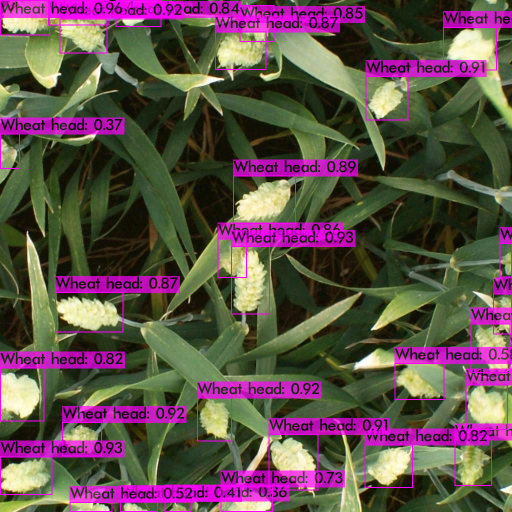

In [31]:
# check prediction sample
predict_sample()

Boundary box generator for complete test dataset

In [32]:
def predict_bboxes():
    # from https://groups.google.com/forum/#!topic/darknet/t6ZwxwHnIMo
    %cd /content/darknet
    ! chmod 777 ./darknet

    ! ./darknet detector test \
    /content/yolo_config_files/yolo.data \
    /content/yolo_config_files/yolov4.cfg \
    /content/yolov4_predict.weights \
    -dont_show -ext_output < /content/yolo_config_files/predict.txt > log.txt


In [33]:
%%capture
predict_bboxes()

In [34]:
# # Uncomment to see predictions file
# ! cat /content/darknet/log.txt

In [35]:
# Convert log.txt to result json file
% cd /content/
! wget --quiet https://raw.githubusercontent.com/Gooogr/Kaggle_Global_Wheat_Detection/master/log_converter.py
! python3 /content/log_converter.py -f /content/darknet/log.txt

/content


In [36]:
sample_submission = pd.read_csv('/content/sample_submission.csv')


In [37]:
sample_submission.head().T

,0,1,2,3,4
image_id,aac893a91,51f1be19e,f5a1f0358,796707dd7,51b3e36ab
PredictionString,1.0 0 0 50 50,1.0 0 0 50 50,1.0 0 0 50 50,1.0 0 0 50 50,1.0 0 0 50 50


In [149]:
with open("/content/log.json", "r") as read_file:
    data = json.load(read_file)

In [150]:
img_id, proba, left_x, top_y, width, height = list([]), [], [], [], [], []
for key in data.keys():
    try:
        df = pd.DataFrame(data[key])
        img_id.extend([key] * len(df))
        proba.extend(df['proba_%'].values)
        left_x.extend(df['left_x'].values)
        top_y.extend(df['top_y'].values)
        width.extend(df['width'].values)
        height.extend(df['height'].values)
    except: #Empty images
        img_id.extend([key])
        proba.extend([np.nan])
        left_x.extend([np.nan])
        top_y.extend([np.nan])
        width.extend([np.nan])
        height.extend([np.nan])
        

result_df = pd.DataFrame(list(zip(img_id, proba, left_x, top_y, width, height)), 
                         columns = ['img', 'proba_%', 'left_x', 'top_y', 'width', 'height'])

### Create submission

In [151]:
sample_submission.head()

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50


In [152]:
result_df['proba_ratio'] = result_df['proba_%'] / 100

In [153]:
def format_list(confidence, x, y, width, height):
    temp_list =  [confidence, x, y, width, height]
    if not np.isnan(confidence):
        return ' '.join(str(item) for item in temp_list)
    else:
        return np.nan

In [154]:
result_df['sub_list'] = result_df.apply(lambda x: format_list(x.proba_ratio, 
                                                              x.left_x, 
                                                              x.top_y, 
                                                              x.width, 
                                                              x.height), axis = 1)

In [155]:
result_df.head()

,img,proba_%,left_x,top_y,width,height,proba_ratio,sub_list
0,796707dd7.jpg,65.0,-1.0,451.0,67.0,77.0,0.65,0.65 -1.0 451.0 67.0 77.0
1,796707dd7.jpg,37.0,53.0,86.0,153.0,88.0,0.37,0.37 53.0 86.0 153.0 88.0
2,796707dd7.jpg,43.0,243.0,-1.0,120.0,45.0,0.43,0.43 243.0 -1.0 120.0 45.0
3,796707dd7.jpg,48.0,355.0,0.0,81.0,60.0,0.48,0.48 355.0 0.0 81.0 60.0
4,796707dd7.jpg,49.0,378.0,629.0,98.0,128.0,0.49,0.49 378.0 629.0 98.0 128.0


In [156]:
# Filter results by confidence ratio
CONFIDENCE_THRESHOLD = 0
filter_condition = (result_df['proba_ratio'] > CONFIDENCE_THRESHOLD) | (result_df['proba_ratio'].isna())
result_df = result_df[filter_condition]

In [157]:
result_df.fillna('', inplace=True)

In [158]:
img_pred_list = []
for img_name in result_df['img'].unique():
    img_pred_list.append(' '.join(str(item) for item in result_df[result_df['img']==img_name].sub_list))

img_names = [item.split('.')[0] for item in result_df['img'].unique()]

In [159]:
submission = pd.DataFrame(zip(img_names, img_pred_list), 
                          columns = ['image_id', 'PredictionString'])

In [160]:
submission

,image_id,PredictionString
0,796707dd7,0.65 -1.0 451.0 67.0 77.0 0.37 53.0 86.0 153.0...
1,f5a1f0358,0.84 0.0 2.0 64.0 64.0 0.86 1.0 841.0 67.0 112...
2,aac893a91,0.37 31.0 448.0 90.0 165.0 0.61 68.0 -5.0 98.0...
3,53f253011,0.73 0.0 389.0 98.0 129.0 0.82 3.0 755.0 114.0...
4,cb8d261a3,0.76 0.0 802.0 40.0 72.0 0.91 25.0 866.0 73.0 ...
5,bad_sample,
6,2fd875eaa,0.93 -2.0 913.0 106.0 76.0 0.37 -2.0 267.0 41....
7,348a992bb,0.62 -2.0 937.0 68.0 85.0 0.38 -1.0 220.0 44.0...
8,51f1be19e,0.37 -1.0 382.0 51.0 112.0 0.63 31.0 1.0 86.0 ...
9,51b3e36ab,0.5 -6.0 432.0 110.0 283.0 0.61 -1.0 905.0 89....


In [161]:
submission.to_csv('submission.csv', index=False)